# 01.Simple Linear Model
---
此範例是測試線性的模型
拿 MNIST 作為 Data Set

## Import Library
---

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt                                     # 圖形相關
import tensorflow as tf                                             # TensorFlow
import numpy as np                                                  # 矩陣運算
from sklearn.metrics import confusion_matrix                        # sklearn 套件下的 confusion_matrix

## 讀測試資料
---
使用 MNIST 的資料來做測試  
並設定為 One Hot Encoding 形式

In [2]:
from tensorflow.examples.tutorials.mnist import input_data          # 將資料的 info 丟進input_data
data = input_data.read_data_sets("/data/MNIST", one_hot = True)     # 把資料載下來

Extracting /data/MNIST\train-images-idx3-ubyte.gz
Extracting /data/MNIST\train-labels-idx1-ubyte.gz
Extracting /data/MNIST\t10k-images-idx3-ubyte.gz
Extracting /data/MNIST\t10k-labels-idx1-ubyte.gz


### One Hot Encoding
---
One Hot Encoding 是一種資料格式  
假設資料有 0 ~ 9  
將用十個 bits 來表示資料  
其中一個 bit 是 1 代表資料屬於這類  
其他為 0 代表資料不屬於這類

In [3]:
data.test.labels[0:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

### 將 One Hot Encoding 轉成真實資料
---
也就是全部資料的真實解

\[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.\] => 代表 1

In [4]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
print(data.test.cls[0:5])

[7 2 1 0 4]


### 資料的維度
---
底下的變數是 MNIST 的資料維度

In [5]:
img_size = 28                                                       # 長
img_size_flat = img_size * img_size                                 # 平面轉成 1D 的資料大小
img_shape = (img_size, img_size)                                    # 整個陣列的維度
num_classes = 10                                                    # 總共有幾個 Class (0 ~ 10)

## Helper Function
---
將圖片顯示出來

In [6]:
def plot_images(images, ground_truth, pred_class=None):
    assert len(images) == len(ground_truth) == 9                    # 設定只顯示九張圖
    
    fig, axes = plt.subplots(3, 3)                                  # 產生一章圖，只有 3 x 3
    fig.subplots_adjust(hspace=0.3, wspace=0.3)                     # 產生間隔

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')      # 將圖片 imshow 出來

        if pred_class is None:                                      # 假設沒有預測的值時，只顯示 True 的 Label
            xlabel = "True: {0}".format(ground_truth[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(ground_truth[i], pred_class[i])
        ax.set_xlabel(xlabel)
        
        # 刪除坐標軸
        ax.set_xticks([])
        ax.set_yticks([])

## 測試 Helper Function
---

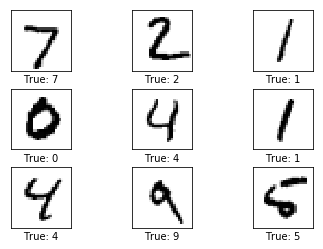

In [7]:
# 拿前九張圖片
images = data.test.images[0:9]

# 給正確的 Ground Truth
ground_truth = data.test.cls[0:9]

# 測試 image 跟 Ground Truth
plot_images(images, ground_truth)

## Tensorflow 須知
---
1. 整個架構都圍繞 Computation Graph，而裡面在做的事情是
    1. 先建造 Graph  
    2. 在跑出結果
2. tf.Session(NODE)  
=> 是執行 Computation Graph 時，需要用的函數，NODE是要執行的節點數
3. tf.placeholder(tf.float32)  
=> 建立一個 Node，一開始先不給資料，只設定它的型態，執行 Session 時，才會把 Input Data 抓進去
4. tf.constant(3, tf.float32)  
=> 建立一個 Node，3 是屬於常數，並設定它的型態(tf.float32)
5. tf.add(NODE1, NODE2)  
=> 產生另外一個 Node，是把 NODE1 和 NODE2 相加
6. NODE1 + NODE2 
=> 等同於 tf.add(NODE1, NODE2)
7. tf.Variable  
=> 是整個 Session 要去學習的參數，根據某個 Cast Function，想辦法找到最小的 Cast

### 先設定輸入相關的變數(Place Holder)
---
產生節點  
來設定 X 變數(輸入是圖片的資料)  
None 是資料輸入的地方  
img_size_flat 是指每個資料會這麼大

In [8]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
print(x)

Tensor("Placeholder:0", shape=(?, 784), dtype=float32)


設定 Y 變數

In [9]:
y_true = tf.placeholder(tf.float32, [None, num_classes])
print(y_true)

Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


設定真實的一維

In [10]:
y_ground_truth = tf.placeholder(tf.int64, [None])
print(y_ground_truth)

Tensor("Placeholder_2:0", shape=(?,), dtype=int64)


## 設定要 Training 的變數 (Variable)
---
根據線性的 Function

要產生 **y = w \* x + b**

<br>
<br>

說明：

每個數字都有一個 Weight 表

每個 Weight 表的值都不同

可以想像數字7

在轉角的那個區塊

因為是重要的 Feature

可能 Weight 會比較大

所以才要每個數字都見一個 Weight 表

In [11]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

設定 Biases

In [12]:
biases = tf.Variable(tf.zeros([num_classes]))

## 將這些 Node 建成 Graph
---
前面所產生了很多個 Node  
要建成 Model  
**y = w \* x + b**

In [13]:
logits = tf.matmul(x, weights) + biases

從 0 ~ 9 的結果中  
取出最大的  
當作結果

In [14]:
y_pred = tf.nn.softmax(logits)        # 把原本的模型轉成機率， logits => [2 1 0] => [0.7 0.3 0]
y_pred_result = tf.argmax(y_pred, 1)  # 把最大的值，變成 1，其他變成 0，並降一個維度

## Cost Function
---
當你設定玩 Function 時 (**y = w \* x + b**)  
你需要找到最佳的 w & b  
這時候你就需要一個 Cost Function  
想辦法讓這個越低越好  
來取得最佳解

而在分類問題的時候  
一定要用 Cross Entropy  
MSE(Mean Squared Error)在 non-convex 的部分
會產生一些問題  
[參考](https://goo.gl/S22b9n)

In [15]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

要從這些 Entropy 的 Vector 中  
取 Mean 當 Cost Function

In [16]:
cost = tf.reduce_mean(cross_entropy)

## 最佳化的方法
---
本篇是使用 Gradient Descent 的方法  
根據 Learning Rate 來逼近 Local Minimum

In [17]:
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(cost)

## Performance
---
接著要來產生比較  
讓 Groud Truth 跟 Pred 的值去做比較  

In [18]:
correct_pred = tf.equal(y_ground_truth, y_pred_result)
print(correct_pred)

Tensor("Equal:0", shape=(?,), dtype=bool)


接著要產生準確率的變數

In [19]:
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## 使用 Tensorflow 跑整個流程
---
上面創建好的 Node 可以創建 Session 跑出結果  

In [20]:
session = tf.Session()

## 初始化參數
---
要先初始化 Variables (就是範例裡的 Weight & Biases) 
需要先初始化

In [21]:
session.run(tf.global_variables_initializer())

## 使用 Helper-Function 來展現最佳化的結果
---
因為 50000 張圖片太多了  
在 Train 的過程中會花費太多時間
所以才用 Stochastic Gradient Descent(簡單來說就是每次抓一堆 Batch 來跑)  
所以先設定 Batch_size


In [22]:
batch_size = 100

來設定一個 Function  
根據要跑幾次 Iterations  
來確認訓練出來的結果

In [23]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # 從 MNIST 裡，抓出 batch size 回來
        # 而回傳出來的值是一個 [2] 的值
        # 所以就把圖片給 x_batch
        # Label 的字給 y_truth_batch
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        feed_pred_train = {x: x_batch,
                           y_true: y_true_batch}
        
        # 跑資料囉
        session.run(optimizer, feed_pred_train)

## 在建立 Helper-Functions 來顯示預測的好壞
---
在 Training 完之後  
要使用 Test Set 來測試 Training 的結果  
所以要建一些 Helper-Function 來確定好壞

In [24]:
feed_test = {x: data.test.images, 
             y_true: data.test.labels,
             y_ground_truth: data.test.cls}
print("Image => \n{0}".format(data.test.images))
print("Label => \n{0}".format(data.test.labels))
print("True Value => \n{0}".format(data.test.cls))

Image => 
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Label => 
[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
True Value => 
[7 2 1 ..., 4 5 6]


Print 準確率

In [25]:
def print_accuracy():
    # 將要跑的 Graph 跟 資了為進去
    acc = session.run(accuracy, feed_test)
    
    # 印出結果
    print("準確率：{0:.1%}".format(acc))

## Confusion Matrix 來視覺化測試結果
---
一邊是表示 True Data  
另一邊是表示 Predict Data  
![](http://www.harrisgeospatial.com/docs/html/images/Classification/ConfusionMatrix.gif)

In [26]:
def plot_confusion_matrix():
    # 拿所有的 Test Set EX:[7, 2, 4]
    cls_true = data.test.cls
    
    # 去做分類，看結果也幾個相近 EX:[7, 1, 4]
    cls_pred = session.run(y_pred_result, feed_dict=feed_test)

    # 從 sklearn 填 Confusion Matrix
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # 印出 Confusion Matrix
    print(cm)

    # 變成一張圖
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

## Plot 出錯誤的圖片
---

In [27]:
def plot_example_errors():
    # 一次執行兩個 Node
    # 所以輸出兩個
    correct, cls_pred = session.run([correct_pred, y_pred_result],
                                    feed_dict=feed_test)

    # 把所有為 True 轉成 False，False 轉成 True
    incorrect = (correct == False)
    
    # 只拿出所有 images 在 incorrect 為 True 的圖片
    images = data.test.images[incorrect]
    
    # 測試維度是不是正確的
    #print(incorrect.shape)
    #print(images.shape)
    
    # 拿到那些在 incorrect 為 True 的 predict result
    cls_pred = cls_pred[incorrect]

    # 拿 Ground Truth
    cls_true = data.test.cls[incorrect]
    
    # 畫圖
    plot_images(images[0:9],
                cls_true[0:9],
                cls_pred[0:9])

## Plot 判斷字的 Weight
---

In [28]:
def plot_weights():
    # 從 Tensorflow 的變數中，拿出 Weight
    w = session.run(weights)
    
    # 找最高和最低值，要壓縮
    # 有正的跟負的
    w_min = np.min(w)
    w_max = np.max(w)

    # 創建 3 x 4 的格子
    # 但後面兩個沒用到
    # 因為只顯示十個
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 只使用前面十個
        if i<10:
            # 原本是一個 img_size_flat x 1 的陣列
            # 要轉乘 28 x 28
            image = w[:, i].reshape(img_shape)

            # 設定 xlabel
            ax.set_xlabel("Weights: {0}".format(i))

            # cmap 是一個參數(Color Map)，根據值，要對應哪一個顏色
            # seismic 是一種對應的方式
            # https://matplotlib.org/examples/color/colormaps_reference.html
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

# 開始測試結果
---
主要分成四個階段：
1. 還沒 Train 之前
2. Train 1個 Iteration
3. Train 10個 Iterations
4. Train 1000個 Iterations

## 還沒 Train之前
---
所有的 Weight 在 global_variables_initializer時  
全部設定成 0  
所以不管什麼值來都是 0

In [29]:
print_accuracy()

準確率：9.8%


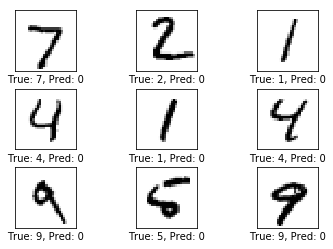

In [30]:
plot_example_errors()

[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892    0    0    0    0    0    0    0    0    0]
 [ 958    0    0    0    0    0    0    0    0    0]
 [1028    0    0    0    0    0    0    0    0    0]
 [ 974    0    0    0    0    0    0    0    0    0]
 [1009    0    0    0    0    0    0    0    0    0]]


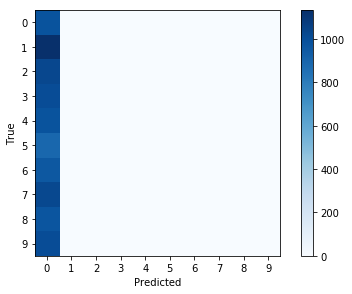

In [31]:
plot_confusion_matrix()

## Train 1次的結果
---

In [32]:
optimize(1)

In [33]:
print_accuracy()

準確率：38.3%


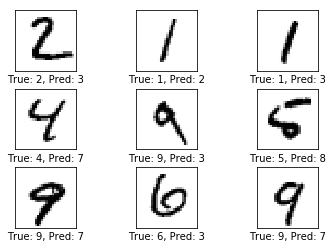

In [34]:
plot_example_errors()

[[752   0   1 164   1   0   0  32  30   0]
 [  0   0  97 784   0   0   0  33 221   0]
 [  7   0 370 443  36   0   0  28 148   0]
 [  1   0   2 980   0   0   0  21   6   0]
 [  3   0   3 130 505   0   0 297  44   0]
 [  1   0  11 606   6   0   1 176  91   0]
 [ 54   0 197 219 117   0  39  19 313   0]
 [  2   0   6  85   2   0   0 908  25   0]
 [  0   0   1 645   0   0   0  47 281   0]
 [  3   0   5 248 157   0   0 576  20   0]]


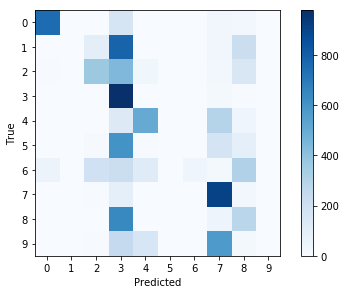

In [35]:
plot_confusion_matrix()

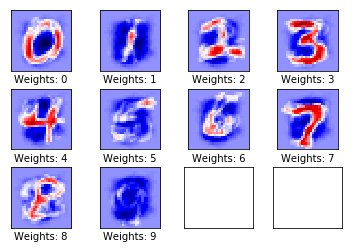

In [36]:
plot_weights()

## Train 10個 Iteration
---

In [37]:
# 因為前面做了一次
optimize(9)

In [38]:
print_accuracy()

準確率：77.2%


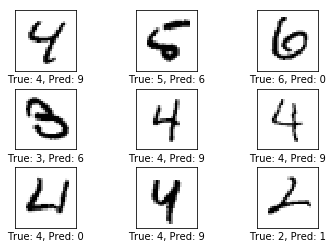

In [39]:
plot_example_errors()

[[ 913    0    1    1    0    1   45    1   16    2]
 [   0 1076    2    1    0    0    5    1   42    8]
 [  38   35  758    6    2    0   74   21   58   40]
 [  21    7   23  760    0   24   25   16   60   74]
 [   8    7    3    0  279    0   61    3   26  595]
 [  31   30    1   68    0  448   70   22  126   96]
 [  23   11    7    0    1    9  897    1    9    0]
 [   5   40   12    0    0    0    5  855   23   88]
 [  11   17    6   15    0   12   23   10  806   74]
 [  15    7    5    4    3    1    7   18   24  925]]


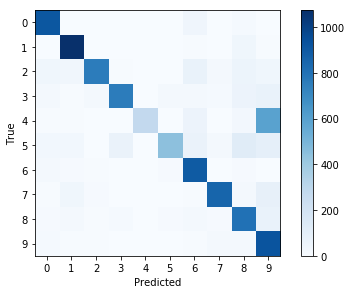

In [40]:
plot_confusion_matrix()

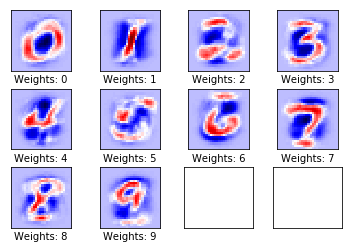

In [41]:
plot_weights()

## Train 1000次 Iteration

In [42]:
optimize(990)

In [43]:
print_accuracy()

準確率：92.1%


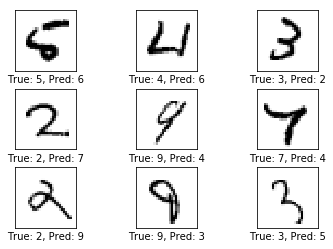

In [44]:
plot_example_errors()

[[ 956    0    2    2    0    5   10    2    3    0]
 [   0 1108    2    2    0    2    4    2   15    0]
 [   7    7  925   10    9    5   14   11   39    5]
 [   3    1   26  898    0   36    3   14   24    5]
 [   1    1    6    1  918    1   15    2   12   25]
 [  10    3    4   22    9  782   17    8   32    5]
 [  10    3    5    1    9   14  912    1    3    0]
 [   2    8   25    6    8    0    0  949    2   28]
 [   5    6    6   16    9   28    9   11  883    1]
 [  10    6    2   12   50    8    0   31   12  878]]


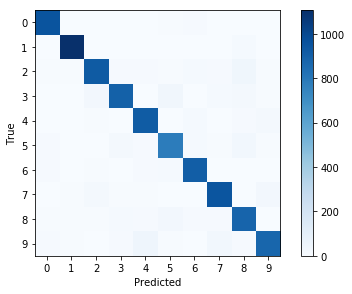

In [45]:
plot_confusion_matrix()

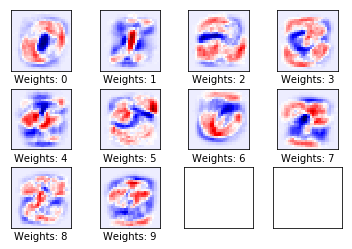

In [46]:
plot_weights()